# Notification

In [228]:
# from twilio.rest import Client
# import os

# account_sid = os.getenv('TWILIO_ACCOUNT_SID')
# auth_token = os.getenv('TWILIO_AUTH_TOKEN')
# twilio_number = os.getenv('TWILIO_SMS_FROM')
# to=os.getenv('TWILIO_SMS_TO')
# message_body = 'See? It\'s working!. OMG You\'re garage door is open!!'
# client = Client(account_sid, auth_token)
# client.messages.create(to=to,
#                        from_=twilio_number,
#                        body=message_body,
#                        status_callback='')

# Simple Detection

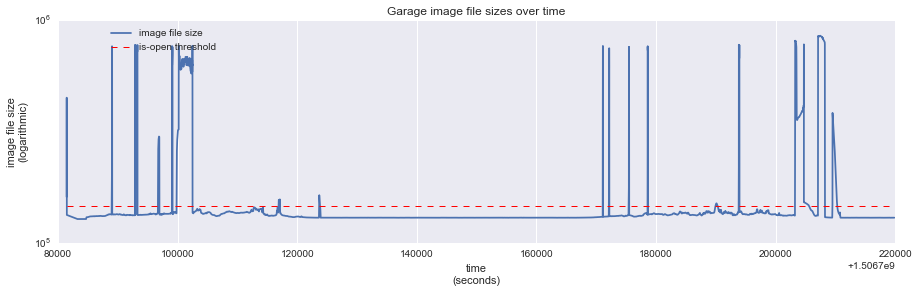

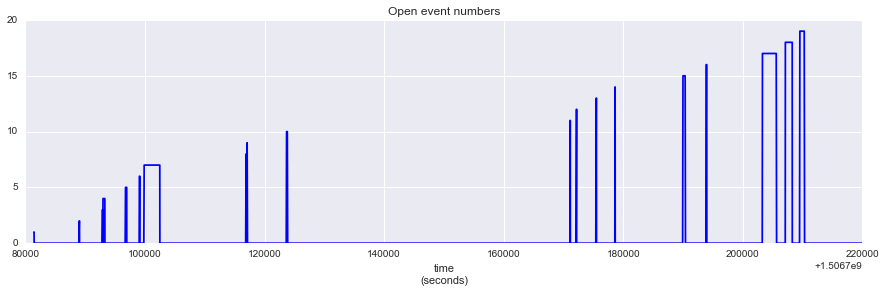

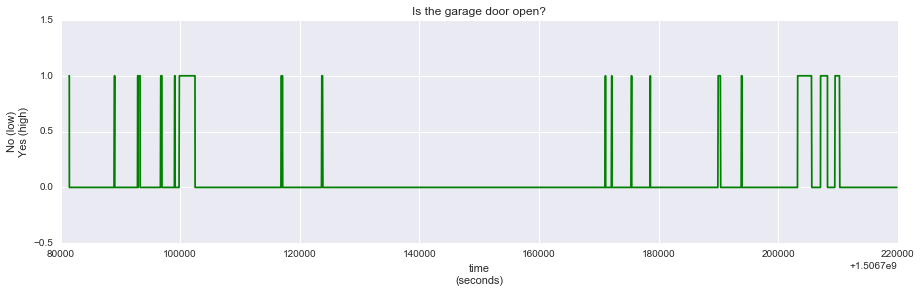

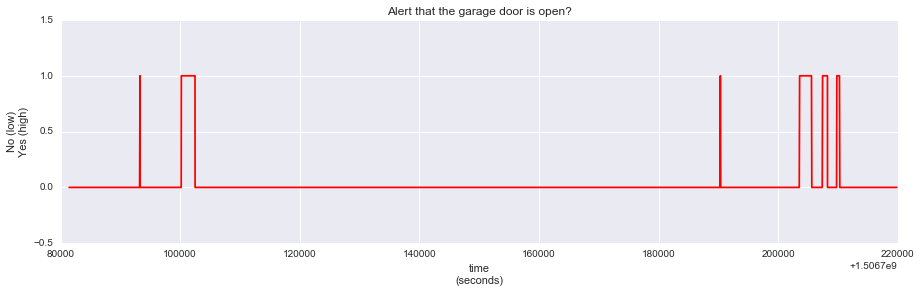

In [229]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from glob import glob
import os
import numpy as np
import pandas as pd
from PIL import Image
import time

filenames = glob('images/*.jpg')
filenames.sort(key=lambda filename: os.stat(filename).st_mtime)
file_sizes = [os.path.getsize(filename) for filename in filenames]
file_times = [os.stat(filename).st_mtime for filename in filenames]

min_file_size = np.min(file_sizes)
max_file_size = np.max(file_sizes)
threshold_fraction = 0.025
threshold_size = threshold_fraction*(max_file_size - min_file_size) + min_file_size

is_open = [1 if size > threshold_size else 0 for size in file_sizes]

open_since = None
is_open_alert = []
event_numbers = []
event_number = 0
for time_step, is_open_now in zip(file_times, is_open):
    if is_open_now and open_since is None:
        open_since = time_step
        event_number += 1
    elif not is_open_now:
        open_since = None
        
    if is_open_now:
        event_numbers.append(event_number)
    else:
        event_numbers.append(0)
        
    if open_since is None:
        is_open_alert.append(0)
    elif time_step - open_since > 5*60:
        is_open_alert.append(1)
    else:
        is_open_alert.append(0)

plt.figure(figsize=(15,4))
plt.plot(file_times, file_sizes, label='image file size')
plt.title('Garage image file sizes over time')
plt.xlabel('time\n(seconds)')
plt.yscale('log')
plt.ylabel('image file size\n(logarithmic)')
plt.plot([np.min(file_times), np.max(file_times)], [threshold_size, threshold_size], color='r', linestyle='--', linewidth=1, label='is-open threshold')
plt.legend(bbox_to_anchor=(0.2, 1))
plt.show()

plt.figure(figsize=(15,4))
plt.plot(file_times, event_numbers, color='b')
plt.title('Open event numbers')
plt.xlabel('time\n(seconds)')
plt.show()

plt.figure(figsize=(15,4))
plt.plot(file_times, is_open, color='g')
plt.ylim(-0.5, 1.5)
plt.title('Is the garage door open?')
plt.xlabel('time\n(seconds)')
plt.ylabel('No (low)\nYes (high)')
plt.show()
        
plt.figure(figsize=(15,4))
plt.plot(file_times, is_open_alert, color='r')
plt.ylim(-0.5, 1.5)
plt.title('Alert that the garage door is open?')
plt.xlabel('time\n(seconds)')
plt.ylabel('No (low)\nYes (high)')
plt.show()


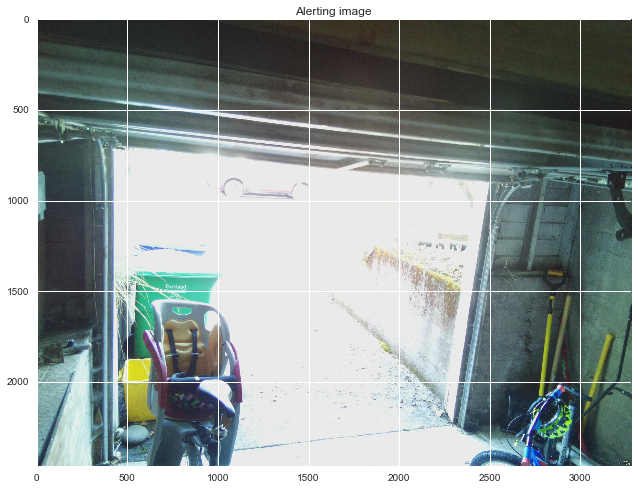

In [230]:
first_alert_filename, _ = filter(lambda (_, is_alert): is_alert, zip(filenames, is_open_alert))[0]
image = Image.open(first_alert_filename)
plt.figure(figsize=(15,8))
plt.title('Alerting image')
plt.imshow(np.asarray(image))

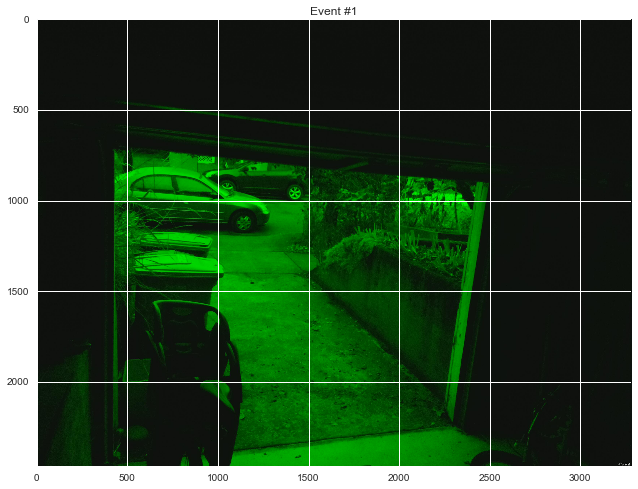

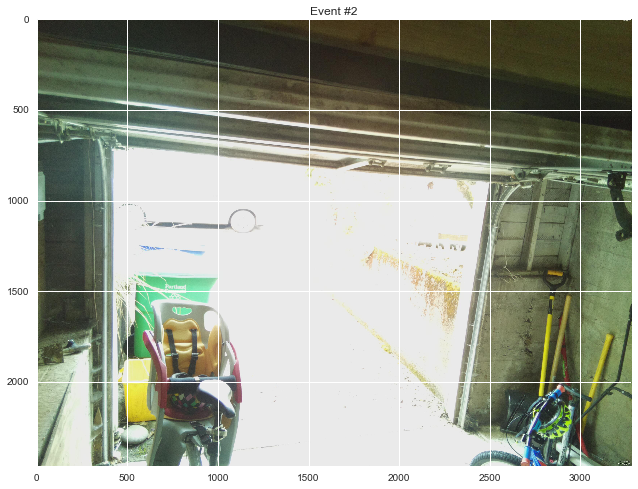

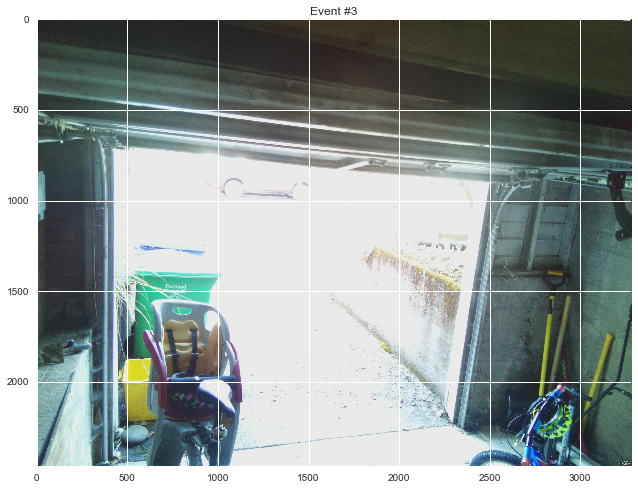

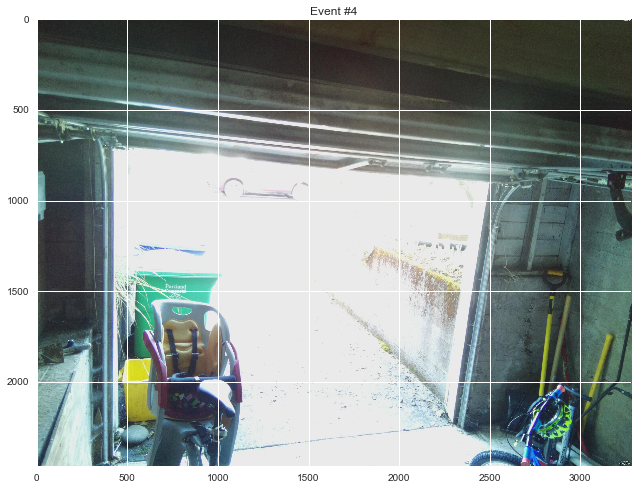

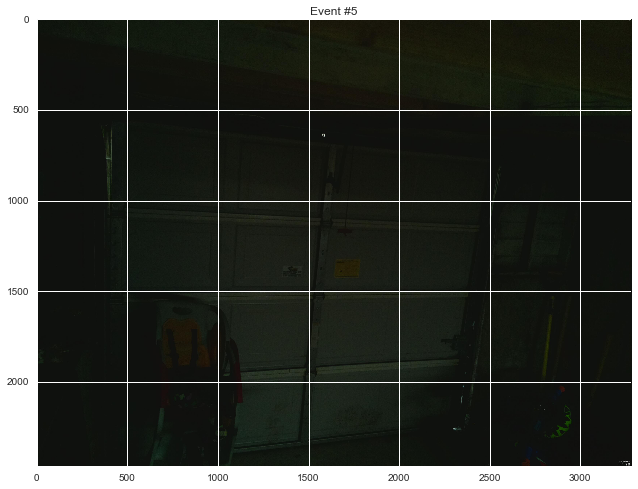

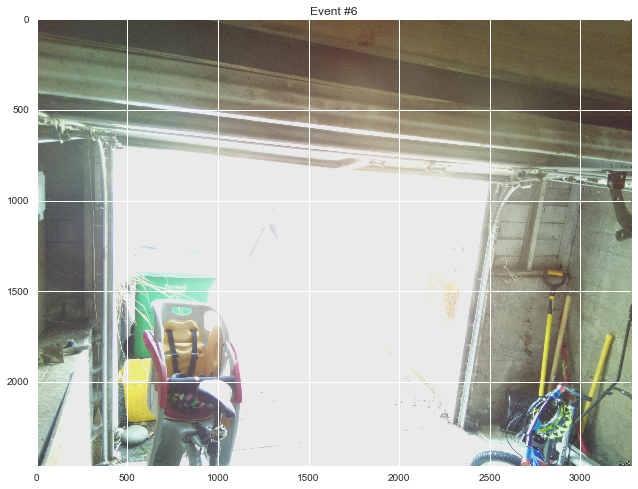

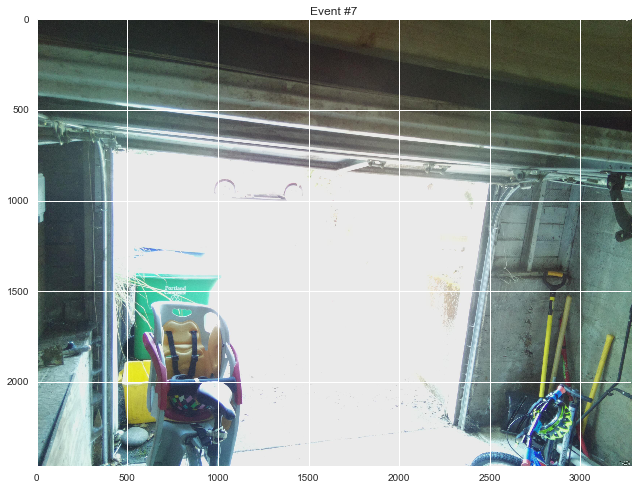

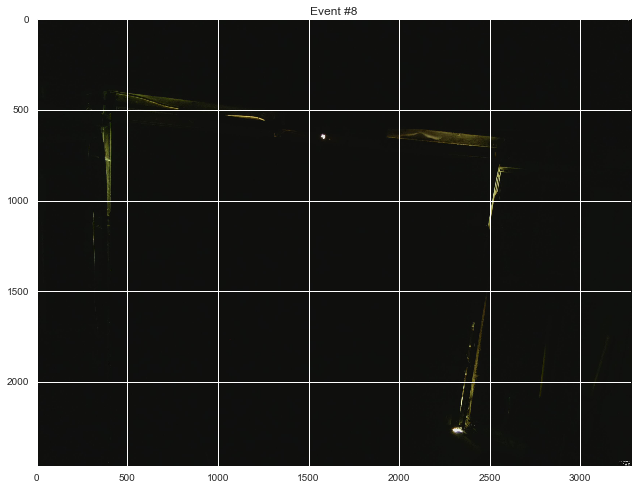

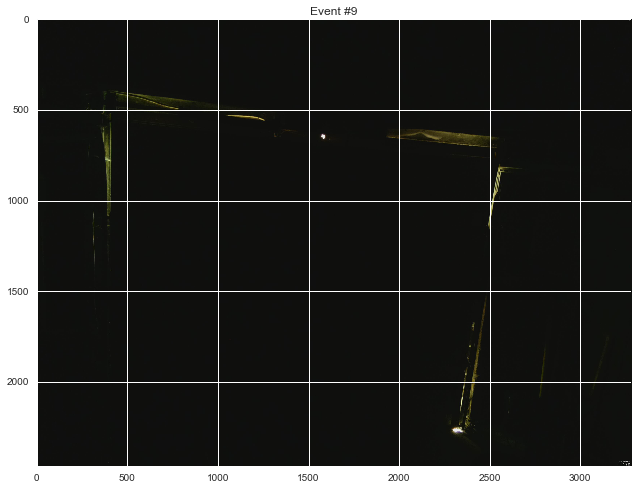

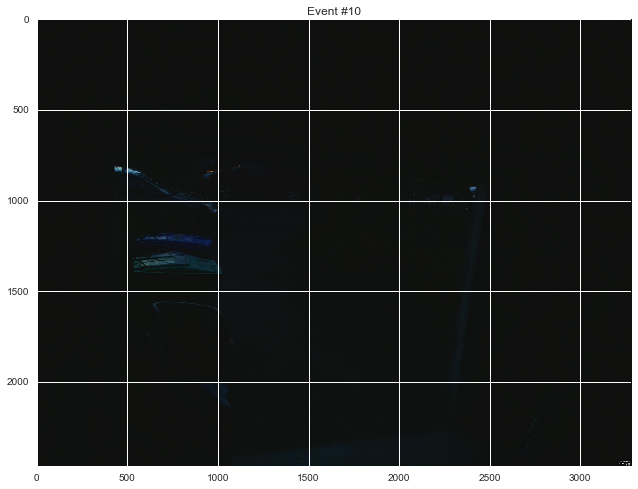

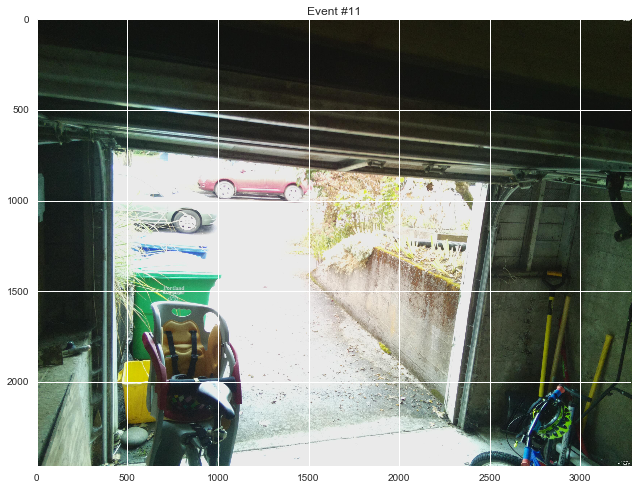

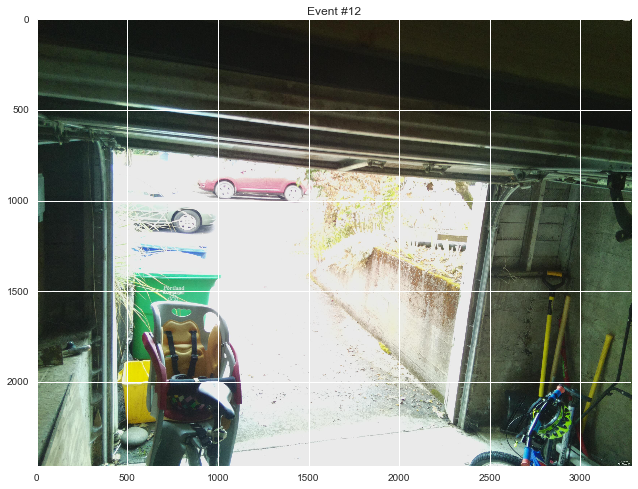

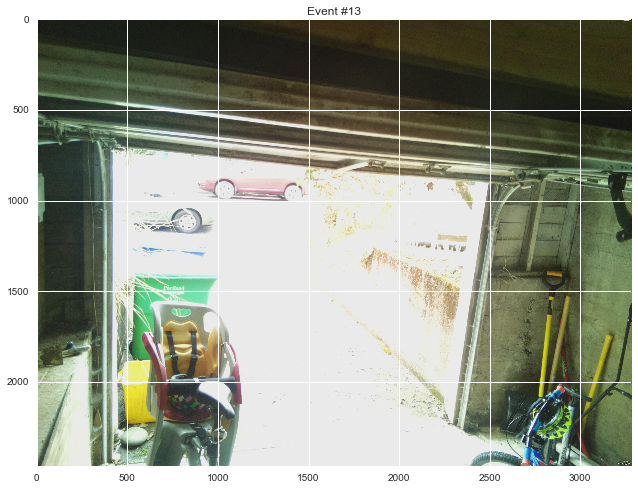

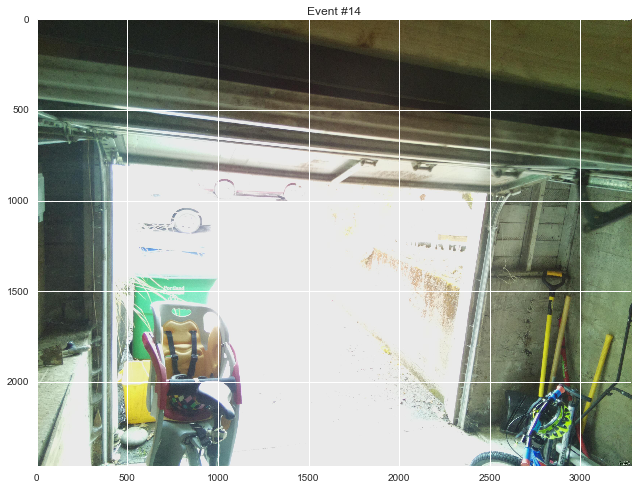

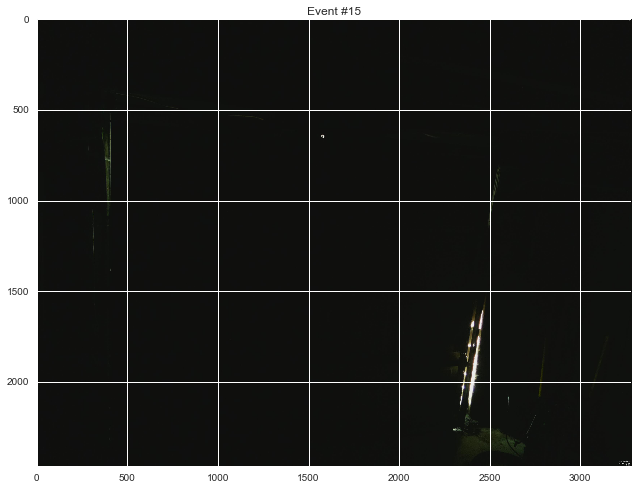

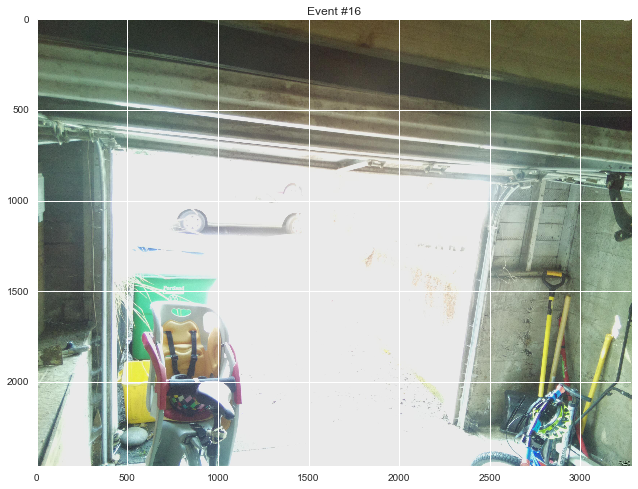

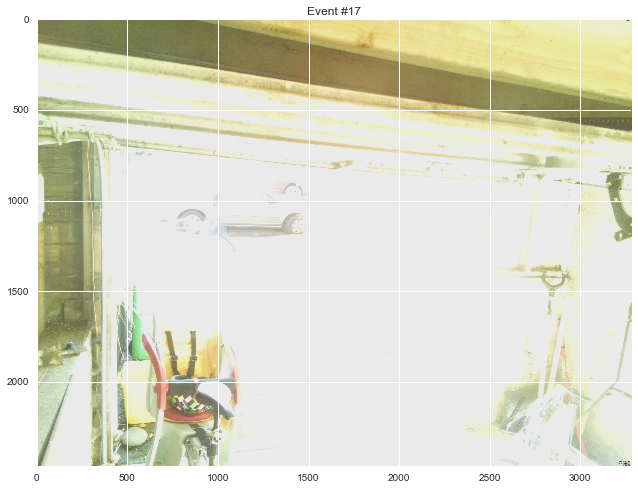

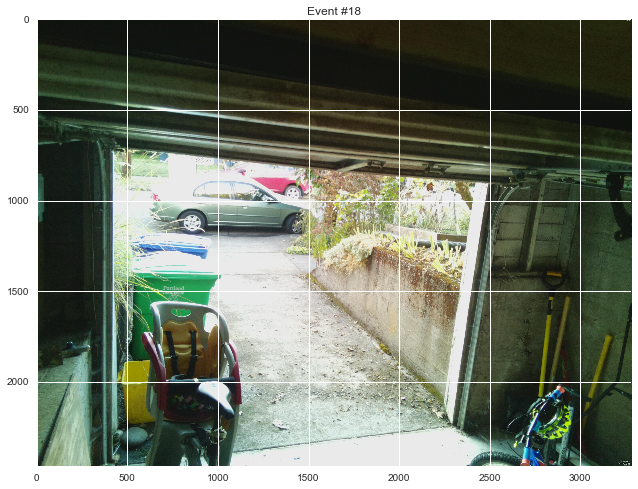

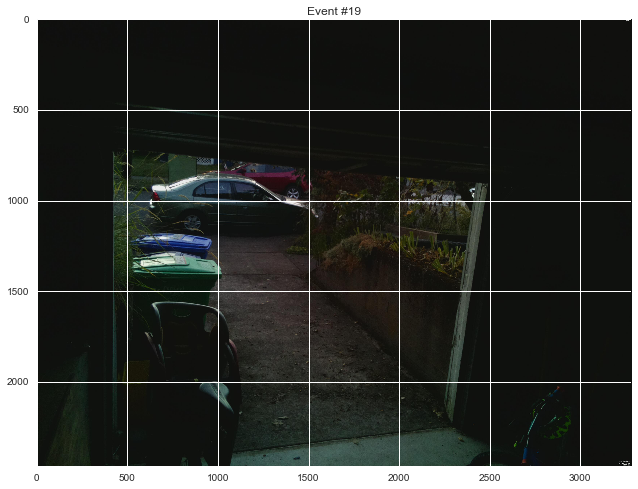

In [231]:
open_filenames = []
event_number = None
for time_step, is_open_now, filename, event_num in zip(file_times, is_open, filenames, event_numbers):
    if is_open_now:
        open_filenames.append(filename)
        event_number = event_num
    else:
        if len(open_filenames) > 0:
            selected_filename = open_filenames[len(open_filenames)/2]
            image = Image.open(selected_filename)
            plt.figure(figsize=(15,8))
            plt.title('Event #'+str(event_number))
            plt.imshow(np.asarray(image))
            plt.show()
        open_filenames = []


In [232]:
df = pd.DataFrame(np.transpose([event_numbers, filenames, file_sizes, is_open]),
                  columns = ['event_number', 'filename', 'file_size', 'is_open']
                 ).convert_objects(convert_numeric=True)
df.loc[ df.event_number == 5, 'is_open' ] = 0
df.loc[ df.event_number == 8, 'is_open' ] = 0
df.loc[ df.event_number == 9, 'is_open' ] = 0
df.loc[ df.event_number == 15, 'is_open' ] = 0
# df.loc[ df.event_number == 11, 'is_open' ] = 0
# df.loc[ df.event_number == 17, 'is_open' ] = 0

df.to_csv('is_open.csv')

/Users/home/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  app.launch_new_instance()


# ML Detection 

In [233]:
df = pd.read_csv('is_open.csv')
df.groupby('is_open').count()

Unnamed: 0  event_number  filename  file_size
is_open                                               
0              2272          2272      2272       2272
1               654           654       654        654

In [234]:
balanced_sample_size = 2*df.groupby('is_open').count()['Unnamed: 0'].min()
balanced_sample_size

1308

In [235]:
from PIL import Image, ImageOps

df['prepared_filename'] = map(lambda filename: filename.replace('images/', 'prepared_images/'), df.filename)
df.head()

Unnamed: 0  event_number                         filename  file_size  \
0           0             1  images/01-20170930072332-00.jpg     161410   
1           1             1  images/01-20170930072333-00.jpg     176703   
2           2             1  images/01-20170930072334-00.jpg     186909   
3           3             1  images/01-20170930072335-00.jpg     196170   
4           4             1  images/01-20170930072336-00.jpg     218983   

   is_open                         prepared_filename  
0        1  prepared_images/01-20170930072332-00.jpg  
1        1  prepared_images/01-20170930072333-00.jpg  
2        1  prepared_images/01-20170930072334-00.jpg  
3        1  prepared_images/01-20170930072335-00.jpg  
4        1  prepared_images/01-20170930072336-00.jpg

In [236]:
# Prepare smaller grey-scale images
for filename, prepared_filename in zip(df.filename, df.prepared_filename):
    if os.path.isfile(prepared_filename):
        continue
    print prepared_filename
    
    image = Image.open(filename)
    image = ImageOps.fit(image, (328, 246), Image.ANTIALIAS)
    image = image.convert('L')
    image.save(prepared_filename)

prepared_images/18-20171001204700-snapshot.jpg
prepared_images/18-20171001204800-snapshot.jpg
prepared_images/18-20171001204900-snapshot.jpg
prepared_images/18-20171001205000-snapshot.jpg
prepared_images/18-20171001205100-snapshot.jpg
prepared_images/18-20171001205200-snapshot.jpg
prepared_images/18-20171001205300-snapshot.jpg
prepared_images/18-20171001205400-snapshot.jpg
prepared_images/18-20171001205500-snapshot.jpg
prepared_images/18-20171001205600-snapshot.jpg
prepared_images/18-20171001205700-snapshot.jpg
prepared_images/18-20171001205800-snapshot.jpg
prepared_images/18-20171001205900-snapshot.jpg
prepared_images/18-20171001210000-snapshot.jpg
prepared_images/18-20171001210100-snapshot.jpg
prepared_images/18-20171001210200-snapshot.jpg
prepared_images/18-20171001210300-snapshot.jpg
prepared_images/18-20171001210400-snapshot.jpg
prepared_images/18-20171001210500-snapshot.jpg
prepared_images/18-20171001210600-snapshot.jpg
prepared_images/18-20171001210700-snapshot.jpg
prepared_imag

In [237]:
# images = [np.reshape(np.asarray(Image.open(filename)), (-1)) for filename in df.filename]

In [238]:
sample_size = balanced_sample_size
samples = pd.concat([df[ df.is_open == 0].sample(n=sample_size/2), df[ df.is_open == 1].sample(n=sample_size/2)])
print samples.shape
samples.sample(n=5)

(1308, 6)


Unnamed: 0  event_number                               filename  \
15            15             1        images/01-20170930072347-00.jpg   
661          661             0  images/11-20170930143000-snapshot.jpg   
2771        2771             0  images/17-20171001191900-snapshot.jpg   
1107        1107             0  images/11-20170930215600-snapshot.jpg   
2122        2122             0  images/15-20171001121600-snapshot.jpg   

      file_size  is_open                               prepared_filename  
15       448143        1        prepared_images/01-20170930072347-00.jpg  
661      132899        0  prepared_images/11-20170930143000-snapshot.jpg  
2771     134211        0  prepared_images/17-20171001191900-snapshot.jpg  
1107     130144        0  prepared_images/11-20170930215600-snapshot.jpg  
2122     137189        0  prepared_images/15-20171001121600-snapshot.jpg

In [239]:
t1 = time.time()
images = [np.reshape(np.asarray(Image.open(filename)), (-1)) for filename in samples.prepared_filename]
t2 = time.time()
print (t2-t1),'(',(t2-t1)/sample_size,')'

2.21540403366 ( 0.00169373397069 )


8.58156704903 ( 0.00656083107724 )


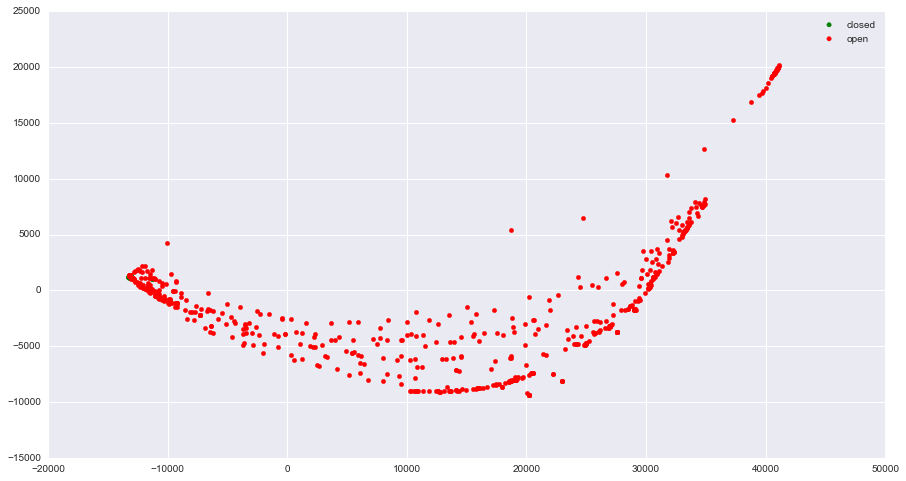

In [240]:
from sklearn.decomposition import PCA
t1 = time.time()
pca = PCA(n_components=2)
pca.fit(images)
vectors = pd.DataFrame(pca.transform(images))
t2 = time.time()
print (t2-t1),'(',(t2-t1)/sample_size,')'

plt.figure(figsize=(15,8))
vectors_closed = vectors[ (samples.is_open == 0).values ]
vectors_open = vectors[ (samples.is_open == 1).values ]
plt.scatter(x=vectors_closed[0], y=vectors_closed[1], color='green', label='closed')
plt.scatter(x=vectors_open[0], y=vectors_open[1], color='red', label='open')
plt.legend()
plt.show()

6.70408701897 ( 0.00512544879126 )


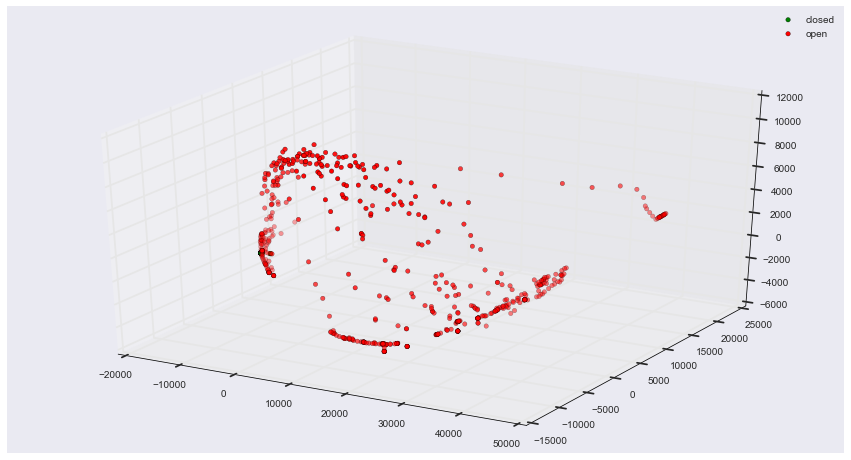

In [241]:
from sklearn.decomposition import PCA
t1 = time.time()
pca = PCA(n_components=3)
pca.fit(images)
vectors = pd.DataFrame(pca.transform(images))
t2 = time.time()
print (t2-t1),'(',(t2-t1)/sample_size,')'

from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(111, projection='3d')
vectors_closed = vectors[ (samples.is_open == 0).values ]
vectors_open = vectors[ (samples.is_open == 1).values ]
ax.scatter(vectors_closed[0], vectors_closed[1], vectors_closed[2], c='green', label='closed')
ax.scatter(vectors_open[0], vectors_open[1],  vectors_open[2], c='red', label='open')
ax.legend()
plt.show()

5.33279109001 ( 0.00407705740827 )


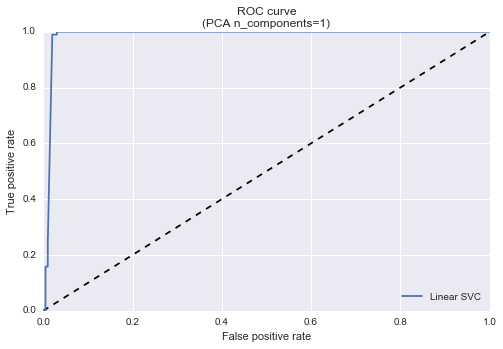

4.82405996323 ( 0.00368811923794 )


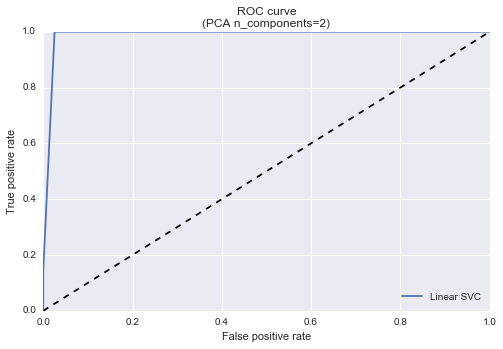

5.0243871212 ( 0.00384127455749 )


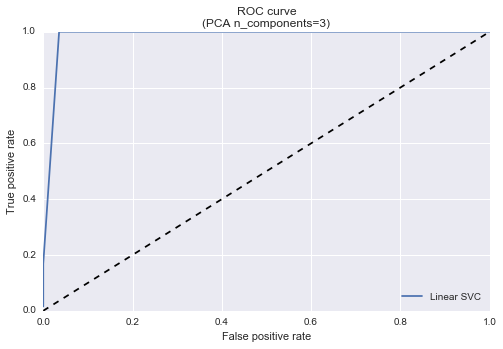

In [242]:
for n_components in [1,2,3]:
    from sklearn.decomposition import PCA
    t1 = time.time()
    pca = PCA(n_components=n_components)
    pca.fit(images)
    vectors = pd.DataFrame(pca.transform(images))
    t2 = time.time()
    print (t2-t1),'(',(t2-t1)/sample_size,')'

    from sklearn.model_selection import train_test_split

    X = vectors
    y = samples.is_open
    X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=.7, stratify=y, random_state=123)

    from sklearn.metrics import roc_curve

    from sklearn import svm
    clf = svm.SVC(probability=True)
    clf.fit(X_train, y_train)  
    y_pred_rt = clf.predict_proba(X_test)[:, 1]
    fpr_rt_lsvc, tpr_rt_lsvc, _ = roc_curve(y_test, y_pred_rt)

    plt.figure(1, figsize=(8,5))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr_rt_lsvc, tpr_rt_lsvc, label='Linear SVC')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve\n(PCA n_components='+str(n_components)+')')
    plt.legend(loc='best')
    plt.show()



4.96966314316 ( 0.00379943665379 )
[[197   0]
 [  1 195]]
[[654   0]
 [  2 652]]


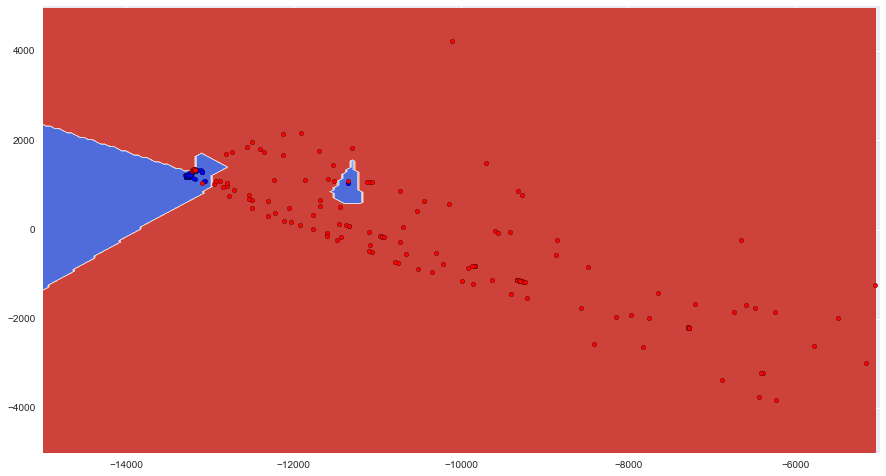

In [243]:
classes = ['open', 'closed']
plot_colors = "br"
plot_steps = 200

from sklearn.decomposition import PCA
t1 = time.time()
pca = PCA(n_components=2)
pca.fit(images)
vectors = pd.DataFrame(pca.transform(images)).values
t2 = time.time()
print (t2-t1),'(',(t2-t1)/sample_size,')'

from sklearn.model_selection import train_test_split

X = vectors
y = samples.is_open
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=.7, stratify=y, random_state=123)

from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
# clf = svm.SVC(probability=False)
# clf = LogisticRegression()
# clf = svm.SVC(kernel='rbf', gamma=0.7)
## clf = svm.SVC(kernel='poly', degree=3)
# clf = svm.LinearSVC()
clf = KNeighborsClassifier(n_neighbors = 2)
# clf = DecisionTreeClassifier()
# clf = LinearDiscriminantAnalysis()
# clf = AdaBoostClassifier()
# clf = RandomForestClassifier(n_estimators=10,max_depth=1, random_state=0)
# clf = GaussianNB()

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
# clf = Pipeline([('polynomial', PolynomialFeatures(2)),
#                 ('classify', clf)])
clf.fit(X_train, y_train)  

from sklearn.metrics import confusion_matrix
y_pred = clf.predict(X_test)
print confusion_matrix(y_test, y_pred)

y_pred = clf.predict(X)
print confusion_matrix(y, y_pred)

plt.figure(figsize=(15,8))
from sklearn.tree import DecisionTreeClassifier
# clf = DecisionTreeClassifier().fit(X_test, y_test)
# x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
# y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
x_min, x_max = [-15000, -5000]
y_min, y_max = [-5000, 5000]
plt.xlim(-15000, -5000)
plt.ylim(-5000, 5000)
xx, yy = np.meshgrid(np.arange(x_min, x_max, (x_max-x_min)/plot_steps), np.arange(y_min, y_max, (y_max-y_min)/plot_steps))

Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
cs = plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm)

for i, color in zip(range(len(classes)), plot_colors):
    idx = np.where(y == i)
    plt.scatter(X[idx, 0], X[idx, 1], c=color, label=classes[i],
                cmap=plt.cm.coolwarm)

In [244]:
X.shape

(1308, 2)